# Prenatal Care Access in North Carolina
## With a Focus on Western North Carolina
**Author:** John Apel | **Date:** February 2026

---

### Research Questions
1. Where are prenatal care access gaps in North Carolina, and which populations are most affected?
2. How does Western NC compare to the Piedmont and Coastal Plain in provider supply and utilization outcomes?
3. What structural factors — provider density, insurance coverage, income, rurality — best explain gaps in care?
4. Which counties are highest-priority intervention targets based on a composite burden index?

### Key Contextual Note — Hurricane Helene
Several Western NC counties experienced significant healthcare infrastructure disruption from Hurricane Helene (September 2024). Per Runkle & Sugg (2025, *NC Medical Journal*), 6 labor and delivery units have closed in WNC since 2015, and before Helene only half of local facilities offered prenatal/delivery care for the region's ~153,000 women aged 18–44. This analysis treats Helene as amplifying pre-existing structural gaps rather than creating them.

### Data Suppression Limitation
CDC WONDER suppresses birth data for counties with small cell sizes (<10 births per category). This excludes all 23 Western NC counties from prenatal utilization analysis — the very counties the analysis was designed to examine. This reflects a structural gap in federal health surveillance for rural Appalachian populations, and is noted as a finding rather than just a limitation (consistent with Runkle & Sugg's recommendation to enhance data collection for this region).

---

## Cell 0 — Setup: Install Libraries & Configure Environment

In [5]:
# Install any missing packages (safe to re-run)
!pip install geopandas requests pandas numpy matplotlib seaborn plotly scipy statsmodels scikit-learn openpyxl pygris --quiet

import pandas as pd
import numpy as np
import requests
import zipfile
import io
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px

import geopandas as gpd
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

# ── Plotting defaults ──────────────────────────────────────────────────────────
plt.rcParams['figure.dpi'] = 130
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style('whitegrid')
PALETTE = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']

# ── Project directories ────────────────────────────────────────────────────────
for folder in ['data/raw', 'data/processed', 'outputs/figures', 'outputs/tables']:
    os.makedirs(folder, exist_ok=True)

print('✅ Libraries loaded and directories created.')

✅ Libraries loaded and directories created.


## Cell 1 — Constants & Geographic Definitions

In [6]:
# NC FIPS code
NC_FIPS = '37'

# Western NC counties (per ARC designation)
WESTERN_NC_COUNTIES = [
    'Alleghany', 'Ashe', 'Avery', 'Buncombe', 'Burke', 'Caldwell',
    'Cherokee', 'Clay', 'Graham', 'Haywood', 'Henderson', 'Jackson',
    'Macon', 'Madison', 'McDowell', 'Mitchell', 'Polk', 'Rutherford',
    'Swain', 'Transylvania', 'Watauga', 'Wilkes', 'Yancey'
]

# Counties with documented Helene infrastructure disruption
HELENE_IMPACTED = [
    'Buncombe', 'Haywood', 'Henderson', 'McDowell', 'Mitchell',
    'Rutherford', 'Transylvania', 'Yancey'
]

# ACS variables to pull (2019-2023 5-year estimates)
ACS_VARIABLES = {
    # Population denominators (women 15-44)
    'B01001_026E': 'women_15_17',
    'B01001_027E': 'women_18_19',
    'B01001_028E': 'women_20',
    'B01001_029E': 'women_21',
    'B01001_030E': 'women_22_24',
    'B01001_031E': 'women_25_29',
    'B01001_032E': 'women_30_34',
    'B01001_033E': 'women_35_39',
    'B01001_034E': 'women_40_44',
    # Health insurance — women 19-44 uninsured
    'B27001_031E': 'women_19_25_uninsured',
    'B27001_034E': 'women_26_34_uninsured',
    'B27001_037E': 'women_35_44_uninsured',
    'B27001_030E': 'women_19_25_total',
    'B27001_033E': 'women_26_34_total',
    'B27001_036E': 'women_35_44_total',
    # Poverty
    'S1701_C03_001E': 'pct_poverty',
    # Vehicles
    'B08201_002E': 'households_no_vehicle',
    'B08201_001E': 'households_total',
    # Broadband (telehealth proxy)
    'B28002_004E': 'households_broadband',
    'B28002_001E': 'households_internet_total',
    # Total population
    'B01003_001E': 'total_population',
}

print(f'✅ Constants defined.')
print(f'   Western NC counties: {len(WESTERN_NC_COUNTIES)}')
print(f'   Helene-impacted counties: {len(HELENE_IMPACTED)}')

✅ Constants defined.
   Western NC counties: 23
   Helene-impacted counties: 8


## Cell 2 — ACS Data (Census API)
**Source:** U.S. Census Bureau ACS 5-Year Estimates, 2019–2023  
**Pulls automatically** — no API key required for county-level queries.

In [7]:
# ── Pull B-table variables ─────────────────────────────────────────────────────
b_vars = [v for v in ACS_VARIABLES.keys() if not v.startswith('S')]

print('Pulling ACS B-table variables...')
var_str = ','.join(['NAME'] + b_vars)
url = f'https://api.census.gov/data/2023/acs/acs5?get={var_str}&for=county:*&in=state:37'
r = requests.get(url, timeout=30)
r.raise_for_status()
data = r.json()
acs_b = pd.DataFrame(data[1:], columns=data[0])
acs_b['fips'] = acs_b['state'] + acs_b['county']
print(f'   B-tables: {len(acs_b)} counties')

# ── Pull poverty from subject table ───────────────────────────────────────────
print('Pulling ACS S-table (poverty)...')
url_s = 'https://api.census.gov/data/2023/acs/acs5/subject?get=NAME,S1701_C03_001E&for=county:*&in=state:37'
r_s = requests.get(url_s, timeout=30)
r_s.raise_for_status()
data_s = r_s.json()
acs_s = pd.DataFrame(data_s[1:], columns=data_s[0])
acs_s['fips'] = acs_s['state'] + acs_s['county']
print(f'   S-tables: {len(acs_s)} counties')

# ── Merge & rename ─────────────────────────────────────────────────────────────
acs_raw = acs_b.merge(acs_s[['fips', 'S1701_C03_001E']], on='fips', how='left')
acs_raw.rename(columns=ACS_VARIABLES, inplace=True)
acs_raw.rename(columns={'NAME': 'county_name'}, inplace=True)
acs_raw['county_name'] = acs_raw['county_name'].str.replace(' County, North Carolina', '', regex=False)

# Convert numeric
for col in list(ACS_VARIABLES.values()) + ['S1701_C03_001E']:
    if col in acs_raw.columns:
        acs_raw[col] = pd.to_numeric(acs_raw[col], errors='coerce')

# ── Engineer features ──────────────────────────────────────────────────────────
acs = acs_raw.copy()

age_cols = ['women_15_17','women_18_19','women_20','women_21',
            'women_22_24','women_25_29','women_30_34','women_35_39','women_40_44']
acs['women_repro_age'] = acs[age_cols].sum(axis=1)

acs['uninsured_women_total'] = (acs['women_19_25_uninsured'] + acs['women_26_34_uninsured'] + acs['women_35_44_uninsured'])
acs['insured_denom'] = (acs['women_19_25_total'] + acs['women_26_34_total'] + acs['women_35_44_total'])
acs['pct_uninsured_women'] = (acs['uninsured_women_total'] / acs['insured_denom'] * 100).round(2)
acs['pct_poverty'] = pd.to_numeric(acs['pct_poverty'], errors='coerce').round(2)
acs['pct_no_vehicle'] = (acs['households_no_vehicle'] / acs['households_total'] * 100).round(2)
acs['pct_broadband'] = (acs['households_broadband'] / acs['households_internet_total'] * 100).round(2)

acs_clean = acs[['fips', 'county_name', 'total_population', 'women_repro_age',
                  'pct_uninsured_women', 'pct_poverty', 'pct_no_vehicle', 'pct_broadband']].copy()
acs_clean.to_csv('data/processed/acs_clean.csv', index=False)

print(f'\n✅ ACS complete: {len(acs_clean)} NC counties')
print(acs_clean.describe().round(2))

Pulling ACS B-table variables...
   B-tables: 100 counties
Pulling ACS S-table (poverty)...
   S-tables: 100 counties

✅ ACS complete: 100 NC counties
       total_population  women_repro_age  pct_uninsured_women  pct_poverty  \
count            100.00           100.00               100.00       100.00   
mean          105843.40         70268.17                28.63        15.41   
std           174681.25        118074.93                 4.50         4.90   
min             3376.00          2019.00                19.01         5.00   
25%            22492.50         14563.00                25.35        11.78   
50%            51777.50         34521.50                28.62        14.45   
75%           116990.25         75774.25                30.97        19.08   
max          1151009.00        769474.00                44.27        28.80   

       pct_no_vehicle  pct_broadband  
count          100.00         100.00  
mean             5.80          84.14  
std              2.46        

## Cell 3 — HRSA HPSA Data (Maternity Care Shortage Designations)
**Source:** HRSA Primary Care HPSA file — maternity care designations are embedded via the `PC MCTA Score` column  
**Pulls automatically** — note: HRSA does not publish a separate maternity care file; the PC MCTA (Primary Care Maternity Care Technical Assistance) score within the Primary Care file identifies maternity-relevant shortage areas.

In [8]:
import requests, io

print('Pulling HRSA HPSA (Primary Care file — contains maternity care designations)...')
hpsa_csv_url = 'https://data.hrsa.gov/DataDownload/DD_Files/BCD_HPSA_FCT_DET_PC.csv'

print('  Downloading (may take ~30 seconds)...')
r = requests.get(hpsa_csv_url, timeout=90)
r.raise_for_status()
hpsa_raw = pd.read_csv(io.StringIO(r.content.decode('utf-8', errors='replace')), low_memory=False)
print(f'  File loaded: {len(hpsa_raw):,} rows')

# ── Filter to NC + active designations ────────────────────────────────────────
nc_mask     = hpsa_raw['Common State Name'].astype(str).str.strip() == 'North Carolina'
active_mask = hpsa_raw['HPSA Status'].astype(str).str.lower().str.strip() != 'withdrawn'
hpsa_nc_all = hpsa_raw[nc_mask & active_mask].copy()
print(f'  Active NC HPSA records: {len(hpsa_nc_all)}')

# ── PC MCTA Score identifies maternity-relevant HPSAs ─────────────────────────
hpsa_nc_all['PC MCTA Score'] = pd.to_numeric(hpsa_nc_all['PC MCTA Score'], errors='coerce')
hpsa_nc_all['HPSA Score']    = pd.to_numeric(hpsa_nc_all['HPSA Score'], errors='coerce')

maternity_mask = hpsa_nc_all['PC MCTA Score'].notna()
hpsa_maternity = hpsa_nc_all[maternity_mask].copy()
score_col = 'PC MCTA Score' if len(hpsa_maternity) > 0 else 'HPSA Score'
if len(hpsa_maternity) == 0:
    hpsa_maternity = hpsa_nc_all.copy()
    print('  ℹ️  No PC MCTA scores found — using general HPSA Score as fallback')
print(f'  Maternity-designated records: {len(hpsa_maternity)} | Score column: {score_col}')

# ── Aggregate to county level ──────────────────────────────────────────────────
hpsa_county = hpsa_maternity.groupby('Common County Name').agg(
    hpsa_score        = (score_col, 'max'),
    hpsa_record_count = (score_col, 'count'),
).reset_index()
hpsa_county.rename(columns={'Common County Name': 'county_name'}, inplace=True)
hpsa_county['hpsa_designated'] = 1

# Pull FIPS for cleaner merging
fips_col = 'Common State County FIPS Code'
fips_map = hpsa_maternity[['Common County Name', fips_col]].drop_duplicates()
fips_map.columns = ['county_name', 'fips']
fips_map['fips'] = fips_map['fips'].astype(str).str.zfill(5)
hpsa_county = hpsa_county.merge(fips_map, on='county_name', how='left')

# ── Fix county name format: "Scotland County, Nc" → "Scotland" ───────────────
hpsa_county['county_name'] = (
    hpsa_county['county_name']
    .str.replace(r'\s*County,\s*Nc$', '', regex=True)
    .str.strip().str.title()
)

hpsa_county.to_csv('data/processed/hpsa_county.csv', index=False)
print(f'\n✅ HPSA complete: {len(hpsa_county)} NC counties designated')
print(f'   Note: 96/100 counties designated reflects near-universal maternity care shortage statewide')
print(hpsa_county.sort_values('hpsa_score', ascending=False).head(10).to_string(index=False))

Pulling HRSA HPSA (Primary Care file — contains maternity care designations)...
  File loaded: 74,254 rows
  Active NC HPSA records: 690
  Maternity-designated records: 689 | Score column: PC MCTA Score

✅ HPSA complete: 96 NC counties designated
   Note: 96/100 counties designated reflects near-universal maternity care shortage statewide
         county_name  hpsa_score  hpsa_record_count  hpsa_designated  fips
 Scotland County, Nc        24.0                  6                1 37165
  Robeson County, Nc        24.0                  4                1 37155
   Craven County, Nc        23.0                  4                1 37049
Edgecombe County, Nc        23.0                  3                1 37065
 Columbus County, Nc        23.0                  5                1 37047
 Richmond County, Nc        23.0                  2                1 37153
  Caswell County, Nc        22.0                  2                1 37033
    Anson County, Nc        22.0                  4        

## Cell 4 — USDA Rural-Urban Continuum Codes
**Source:** USDA ERS Rural-Urban Continuum Codes 2023  
**Pulls automatically** — file is in long format (one row per county per attribute); filtered to RUCC_2023 rows.

In [9]:
rucc_url = 'https://ers.usda.gov/sites/default/files/_laserfiche/DataFiles/53251/Ruralurbancontinuumcodes2023.csv'

print('Downloading USDA RUCC 2023...')
r = requests.get(rucc_url, timeout=30, headers={'User-Agent': 'Mozilla/5.0'})
r.raise_for_status()
rucc_raw = pd.read_csv(io.StringIO(r.content.decode('utf-8', errors='replace')))
print(f'  Loaded: {len(rucc_raw):,} rows (long format — one row per county per attribute)')

# Long format: filter to RUCC_2023 attribute rows, then NC
rucc_2023 = rucc_raw[rucc_raw['Attribute'] == 'RUCC_2023'].copy()
rucc_nc   = rucc_2023[rucc_2023['State'].str.strip() == 'NC'].copy()

rucc_nc['fips']        = rucc_nc['FIPS'].astype(str).str.zfill(5)
rucc_nc['rucc_code']   = rucc_nc['Value'].astype(int)
rucc_nc['rural_binary'] = (rucc_nc['rucc_code'] >= 4).astype(int)
rucc_nc['rural_label'] = rucc_nc['rural_binary'].map({0: 'Metro', 1: 'Rural/Non-metro'})

rucc_clean = rucc_nc[['fips', 'rucc_code', 'rural_binary', 'rural_label']].copy()
rucc_clean.to_csv('data/processed/rucc_nc.csv', index=False)

print(f'\n✅ RUCC saved: {len(rucc_clean)} NC counties')
print(rucc_clean['rural_label'].value_counts())

  Loaded: 9,703 rows (long format — one row per county per attribute)

✅ RUCC saved: 100 NC counties
rural_label
Rural/Non-metro    55
Metro              45
Name: count, dtype: int64


## Cell 5 — CDC WONDER Natality Data
**Source:** CDC WONDER Natality, 2016–2024  
**⚠️ Manual download required** — CDC WONDER does not allow programmatic access.

### Download Instructions:
1. Go to: **https://wonder.cdc.gov/natality-current.html**
2. **Section 1 (Organize):** Group Results By = `County of Residence`, And By = `Trimester Prenatal Care Began`
3. **Section 2:** Select State = North Carolina (all counties)
4. **Sections 3–8:** Leave all defaults unchanged
5. **Section 10:** Change year range to **2016–2024**
6. Click **Send** → on results page click **Export → Tab-delimited text**
7. Save file, then upload to Colab — it will land at `/content/`

### Data Suppression Note:
CDC WONDER suppresses birth counts for county-trimester cells with fewer than 10 births. This results in **only 28 of 100 NC counties** having complete prenatal utilization data — and crucially, **zero of 23 Western NC counties** are represented. This is treated as a substantive finding: the counties most at risk are least visible in federal surveillance data. The burden index (Step 4) is therefore built from provider density and SDOH indicators rather than utilization rates.

In [15]:
import shutil

# Copy file from Colab upload location to project data folder
wonder_src = '/content/cdc_wonder_natality_nc.txt'
wonder_dst = 'data/raw/cdc_wonder_natality_nc.txt'

if os.path.exists(wonder_src):
    shutil.copy(wonder_src, wonder_dst)
    print(f'✅ File copied to {wonder_dst}')
elif os.path.exists(wonder_dst):
    print(f'✅ File already at {wonder_dst}')
else:
    print('⚠️  File not found. Please upload cdc_wonder_natality_nc.txt to Colab first.')

# ── Load & process ─────────────────────────────────────────────────────────────
wonder_path = 'data/raw/cdc_wonder_natality_nc.txt'

if os.path.exists(wonder_path):
    wonder_raw = pd.read_csv(
        wonder_path, sep='\t',
        na_values=['Suppressed', 'Not Applicable', 'Missing', ''],
        low_memory=False
    )
    wonder_raw.columns = wonder_raw.columns.str.strip()

    county_col    = 'County of Residence'
    county_code   = 'County of Residence Code'
    trimester_col = 'Trimester Prenatal Care Began'

    wonder_df = wonder_raw.dropna(subset=[county_code, trimester_col]).copy()
    print(f'Rows after filter: {len(wonder_df)} | Unique counties: {wonder_df[county_col].nunique()}')

    wonder_df['fips']        = wonder_df[county_code].astype(float).astype(int).astype(str).str.zfill(5)
    wonder_df['county_name'] = wonder_df[county_col].str.replace(r'\s*County,\s*NC.*$', '', regex=True).str.strip()
    wonder_df['births']      = pd.to_numeric(wonder_df['Births'], errors='coerce')
    wonder_df['trimester']   = wonder_df[trimester_col].str.strip()

    # ── Pivot long → wide ─────────────────────────────────────────────────────
    pivot = wonder_df.pivot_table(
        index=['fips', 'county_name'], columns='trimester',
        values='births', aggfunc='sum'
    ).reset_index()
    pivot.columns.name = None

    trimester_map = {
        '1st to 3rd month':      'births_1st_trimester',
        '4th to 6th month':      'births_2nd_trimester',
        '7th to final month':    'births_3rd_trimester',
        'No prenatal care':      'births_no_prenatal',
        'Unknown or Not Stated': 'births_unknown',
    }
    pivot.rename(columns={k: v for k, v in trimester_map.items() if k in pivot.columns}, inplace=True)

    trim_cols = [v for v in trimester_map.values() if v in pivot.columns]
    pivot['total_births'] = pivot[trim_cols].sum(axis=1, min_count=1)

    for col, pct in [('births_1st_trimester', 'pct_1st_trimester'),
                      ('births_3rd_trimester', 'pct_3rd_trimester'),
                      ('births_no_prenatal',   'pct_no_prenatal')]:
        if col in pivot.columns:
            pivot[pct] = (pivot[col] / pivot['total_births'] * 100).round(2)

    late = [c for c in ['births_3rd_trimester', 'births_no_prenatal'] if c in pivot.columns]
    if late:
        pivot['births_late_no_prenatal'] = pivot[late].sum(axis=1, min_count=1)
        pivot['pct_late_no_prenatal']    = (pivot['births_late_no_prenatal'] / pivot['total_births'] * 100).round(2)

    pivot['has_suppressed_data'] = pivot[trim_cols].isna().any(axis=1).astype(int)

    wonder_clean = pivot.copy()
    wonder_clean.to_csv('data/processed/cdc_wonder_clean.csv', index=False)

    n_counties = len(wonder_clean)
    n_suppressed = wonder_clean['has_suppressed_data'].sum()
    print(f'\n✅ CDC WONDER processed: {n_counties} counties with data')
    print(f'   Suppressed (small counties excluded): {100 - n_counties} counties')
    print(f'   Counties with partial suppression: {n_suppressed}')
    print(f'   ⚠️  All 23 Western NC counties are suppressed — noted as key limitation')
    print(wonder_clean[['county_name','total_births','pct_1st_trimester','pct_late_no_prenatal']].head(8))
else:
    wonder_clean = None
    print('⚠️  CDC WONDER file not found — prenatal utilization rates will be NaN in master dataset.')
    print('   Burden index will use provider density + SDOH indicators only (all 100 counties).')

✅ File copied to data/raw/cdc_wonder_natality_nc.txt
Rows after filter: 140 | Unique counties: 28

✅ CDC WONDER processed: 28 counties with data
   Suppressed (small counties excluded): 72 counties
   Counties with partial suppression: 0
   ⚠️  All 23 Western NC counties are suppressed — noted as key limitation
  county_name  total_births  pct_1st_trimester  pct_late_no_prenatal
0    Alamance       17269.0              71.77                  8.03
1   Brunswick        9767.0              76.56                  5.63
2    Buncombe       21790.0              87.58                  2.96
3    Cabarrus       23476.0              77.34                  5.69
4     Catawba       15007.0              79.52                  6.61
5      Craven       11855.0              72.65                  7.68
6  Cumberland       47624.0              73.39                  6.71
7    Davidson       15927.0              78.09                  7.45


## Cell 6 — Provider Density (HRSA AHRF)
**Source:** HRSA Area Health Resources Files 2024–2025  
**Pulls automatically** — uses `tot_md_do_obgyn_gen_23` (total MD+DO general OB/GYNs) and `md_nf_obgyn_subsp_23` (subspecialists).  
**Note:** AHRF does not include CNMs as a separate county-level field; this is noted as a limitation.

In [16]:
url = 'https://data.hrsa.gov/DataDownload/AHRF/AHRF_2024-2025_CSV.zip'
print('Downloading AHRF 2024-2025...')
r = requests.get(url, timeout=120)
r.raise_for_status()

with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    county_file = next(f for f in z.namelist() if 'county' in f.lower() and f.endswith('.csv'))
    print(f'  Loading: {county_file}')
    with z.open(county_file) as f:
        ahrf_df = pd.read_csv(f, low_memory=False)

print(f'  AHRF loaded: {ahrf_df.shape[0]:,} rows x {ahrf_df.shape[1]:,} columns')

# ── Filter to NC and extract provider counts ───────────────────────────────────
ahrf_nc = ahrf_df[ahrf_df['fips_st'].astype(str).str.strip() == '37'].copy()
ahrf_nc['fips'] = ahrf_nc['fips_st_cnty'].astype(str).str.zfill(5)

# tot_md_do_obgyn_gen_23 = total MD+DO general OB/GYNs (most complete, includes both MD and DO)
# md_nf_obgyn_subsp_23  = OB/GYN subspecialists (MFM, REI, GYN-ONC, FPMRS)
ahrf_nc['obgyn_count']       = pd.to_numeric(ahrf_nc['tot_md_do_obgyn_gen_23'], errors='coerce').fillna(0)
ahrf_nc['obgyn_subsp_count'] = pd.to_numeric(ahrf_nc['md_nf_obgyn_subsp_23'],  errors='coerce').fillna(0)
ahrf_nc['total_providers']   = ahrf_nc['obgyn_count'] + ahrf_nc['obgyn_subsp_count']

ahrf_clean = ahrf_nc[['fips', 'obgyn_count', 'obgyn_subsp_count', 'total_providers']].copy()
ahrf_clean.to_csv('data/processed/ahrf_providers.csv', index=False)

print(f'\n✅ Provider data: {len(ahrf_clean)} NC counties')
print(f'   Counties with zero OB/GYNs: {(ahrf_clean["obgyn_count"] == 0).sum()} of {len(ahrf_clean)}')
print(ahrf_clean.describe().round(2))

  Loading: NCHWA-2024-2025+AHRF+COUNTY+CSV/AHRF2025.csv
  AHRF loaded: 3,235 rows x 4,352 columns

✅ Provider data: 100 NC counties
   Counties with zero OB/GYNs: 27 of 100
       obgyn_count  obgyn_subsp_count  total_providers
count       100.00             100.00           100.00
mean         14.48               1.97            16.45
std          36.02               6.05            41.49
min           0.00               0.00             0.00
25%           0.00               0.00             0.00
50%           3.00               0.00             4.00
75%           8.25               1.00             9.00
max         243.00              32.00           273.00


## Cell 7 — NC County Shapefile (Census TIGER via pygris)
**Source:** U.S. Census Bureau TIGER/Line 2023 via the `pygris` package  
**Pulls automatically** — pygris handles Census URL changes automatically.

In [17]:
import pygris

print('Downloading NC county shapefile via pygris...')
gdf = pygris.counties(state='NC', year=2023, cb=True)

gdf['fips']        = gdf['GEOID'].astype(str).str.zfill(5)
gdf['county_name'] = gdf['NAME'].str.strip()

gdf.to_file('data/processed/nc_counties.gpkg', driver='GPKG')
print(f'✅ Shapefile loaded: {len(gdf)} counties | CRS: {gdf.crs}')

Using FIPS code '37' for input 'NC'
✅ Shapefile loaded: 100 counties | CRS: EPSG:4269


## Cell 8 — Build Master Dataset
Merges all sources into a single county-level dataframe keyed on FIPS (100 NC counties).

In [18]:
# ── Load from disk if re-running after kernel restart ─────────────────────────
def load_if_exists(path, var_name):
    if os.path.exists(path):
        print(f'  ✅ Loaded: {path}')
        return pd.read_csv(path)
    print(f'  ⚠️  Missing: {path} — run Cell {var_name} first')
    return None

if 'acs_clean' not in dir():   acs_clean   = load_if_exists('data/processed/acs_clean.csv',    '2')
if 'hpsa_county' not in dir(): hpsa_county = load_if_exists('data/processed/hpsa_county.csv',  '3')
if 'rucc_clean' not in dir():  rucc_clean  = load_if_exists('data/processed/rucc_nc.csv',       '4')
if 'wonder_clean' not in dir(): wonder_clean = load_if_exists('data/processed/cdc_wonder_clean.csv', '5')
if 'ahrf_clean' not in dir():  ahrf_clean  = load_if_exists('data/processed/ahrf_providers.csv','6')

print('\nDataset status:')
for name, df in [('ACS',acs_clean),('HPSA',hpsa_county),('RUCC',rucc_clean),
                  ('CDC WONDER',wonder_clean),('AHRF',ahrf_clean)]:
    print(f'  {name}: {len(df)} rows' if df is not None else f'  {name}: ❌ not loaded')

# ── Merge on FIPS ──────────────────────────────────────────────────────────────
master = acs_clean.copy()
master['fips'] = master['fips'].astype(str)

if rucc_clean is not None:
    rucc_clean['fips'] = rucc_clean['fips'].astype(str)
    master = master.merge(rucc_clean[['fips','rucc_code','rural_binary','rural_label']], on='fips', how='left')

if hpsa_county is not None:
    hpsa_county['fips'] = hpsa_county['fips'].astype(str)
    master = master.merge(hpsa_county[['fips','hpsa_score','hpsa_designated']], on='fips', how='left')
    master['hpsa_designated'] = master['hpsa_designated'].fillna(0).astype(int)
    master['hpsa_score']      = master['hpsa_score'].fillna(0)

if wonder_clean is not None:
    wonder_clean['fips'] = wonder_clean['fips'].astype(str)
    master = master.merge(wonder_clean.drop(columns=['county_name'], errors='ignore'), on='fips', how='left')

if ahrf_clean is not None:
    ahrf_clean['fips'] = ahrf_clean['fips'].astype(str)
    master = master.merge(ahrf_clean, on='fips', how='left')
    master['providers_per_10k'] = (master['total_providers'] / master['women_repro_age'] * 10000).round(2)

# ── Regional flags ─────────────────────────────────────────────────────────────
master['region']          = 'Piedmont/Coastal'
master.loc[master['county_name'].isin(WESTERN_NC_COUNTIES), 'region'] = 'Western NC'
master['western_nc']      = master['county_name'].isin(WESTERN_NC_COUNTIES).astype(int)
master['helene_impacted'] = master['county_name'].isin(HELENE_IMPACTED).astype(int)

master.to_csv('data/processed/master_county.csv', index=False)
print(f'\n✅ Master dataset: {master.shape[0]} counties x {master.shape[1]} columns')
print(f'   Western NC: {master["western_nc"].sum()} | Helene-impacted: {master["helene_impacted"].sum()}')
print(f'   Counties with prenatal utilization data: {master["pct_late_no_prenatal"].notna().sum()} (CDC WONDER suppression)')
master.head()


Dataset status:
  ACS: 100 rows
  HPSA: 96 rows
  RUCC: 100 rows
  CDC WONDER: 28 rows
  AHRF: 100 rows

✅ Master dataset: 100 counties x 32 columns
   Western NC: 23 | Helene-impacted: 8
   Counties with prenatal utilization data: 27 (CDC WONDER suppression)


,fips,county_name,total_population,women_repro_age,pct_uninsured_women,pct_poverty,pct_no_vehicle,pct_broadband,rucc_code,rural_binary,...,births_late_no_prenatal,pct_late_no_prenatal,has_suppressed_data,obgyn_count,obgyn_subsp_count,total_providers,providers_per_10k,region,western_nc,helene_impacted
0,37001,Alamance,174286,119249,32.22,14.1,4.43,88.19,3,0,...,1387.0,8.03,0.0,10.0,0.0,10.0,0.84,Piedmont/Coastal,0,0
1,37003,Alexander,36440,22550,28.67,12.1,2.58,84.63,2,0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,Piedmont/Coastal,0,0
2,37005,Alleghany,11075,6819,22.65,17.4,6.38,81.05,9,1,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,Western NC,1,0
3,37007,Anson,21903,14053,30.13,21.2,8.60,84.39,1,0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,Piedmont/Coastal,0,0
4,37009,Ashe,26831,16667,23.18,14.1,4.99,80.18,9,1,...,NaN,NaN,NaN,1.0,0.0,1.0,0.60,Western NC,1,0


---
## Step 1 — Descriptive Statistics & State Overview

In [19]:
key_vars = ['providers_per_10k','pct_uninsured_women','pct_poverty',
            'pct_no_vehicle','pct_late_no_prenatal','pct_no_prenatal','hpsa_score','pct_broadband']
key_vars_present = [v for v in key_vars if v in master.columns]

desc = master[key_vars_present].describe().round(2)
print('=== Statewide Summary Statistics ===')
print(desc)
desc.to_csv('outputs/tables/descriptive_stats.csv')

=== Statewide Summary Statistics ===
       providers_per_10k  pct_uninsured_women  pct_poverty  pct_no_vehicle  \
count             100.00               100.00       100.00          100.00   
mean                1.27                28.63        15.41            5.80   
std                 1.62                 4.50         4.90            2.46   
min                 0.00                19.01         5.00            1.55   
25%                 0.00                25.35        11.78            4.09   
50%                 0.88                28.62        14.45            5.30   
75%                 1.51                30.97        19.08            7.12   
max                10.77                44.27        28.80           17.12   

       pct_late_no_prenatal  pct_no_prenatal  hpsa_score  pct_broadband  
count                 27.00            27.00      100.00         100.00  
mean                   7.25             2.74       17.56          84.14  
std                    2.39           

### Figure 1: Prenatal Provider Density Map

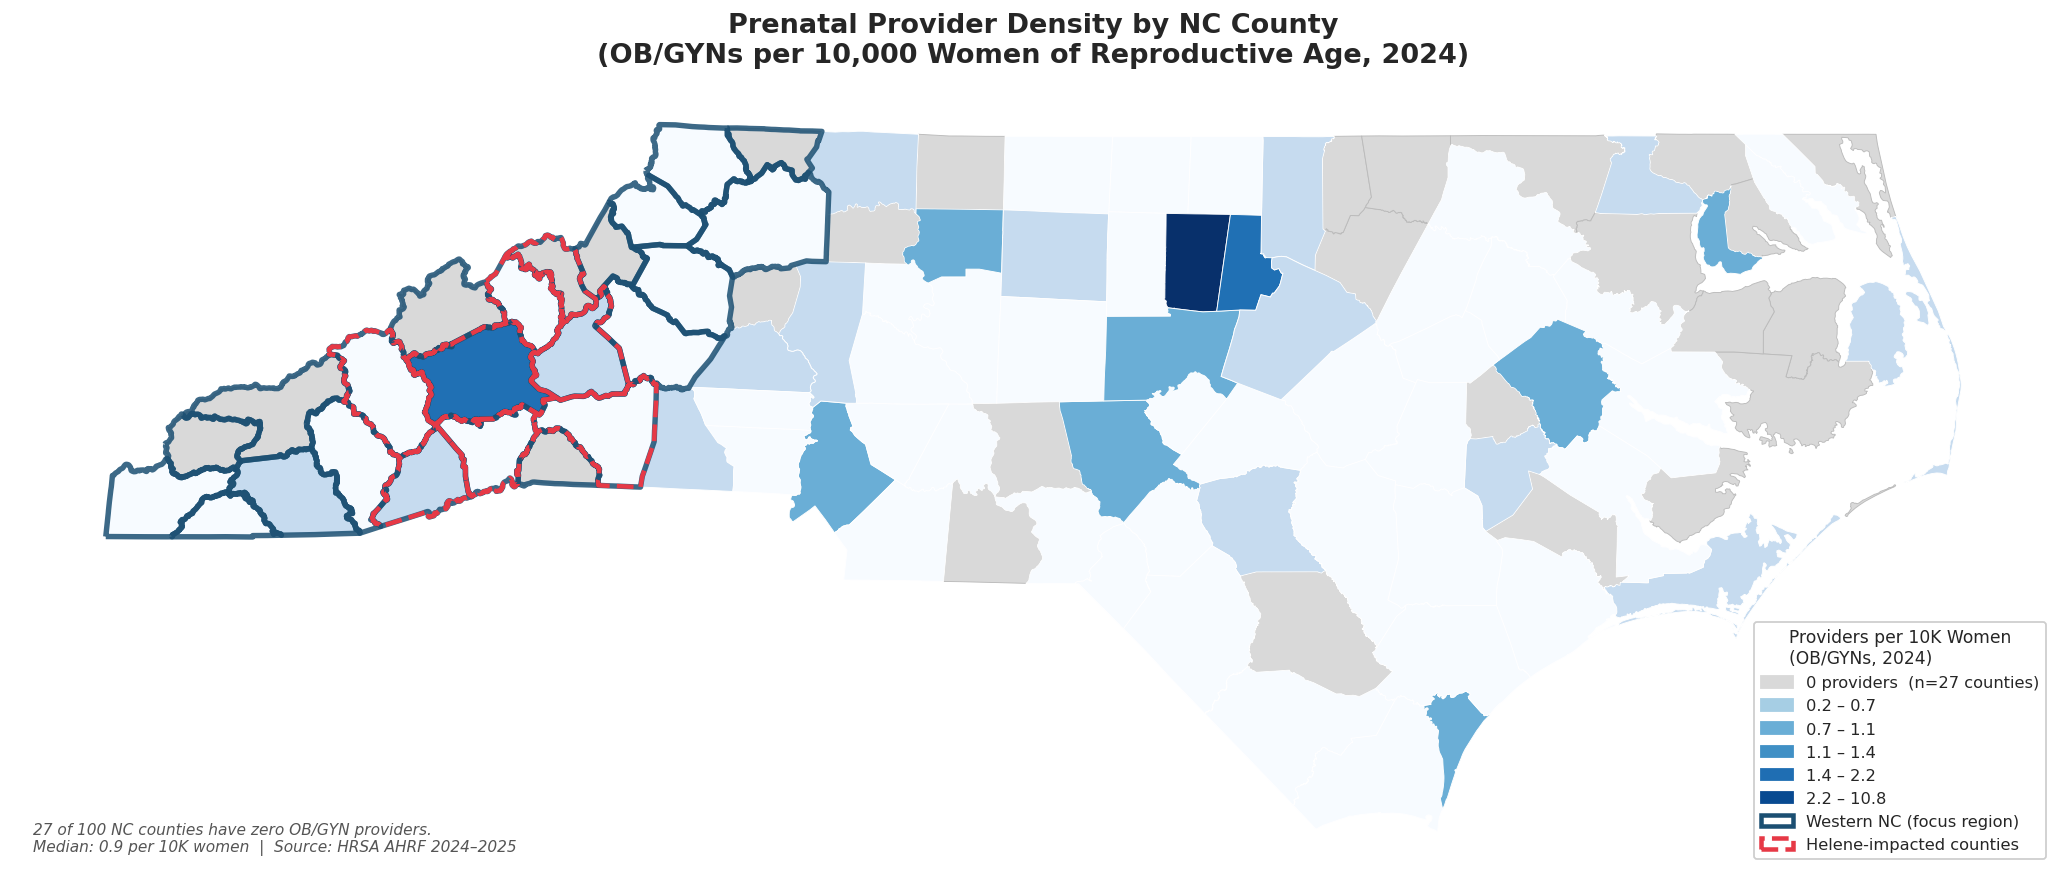

✅ Map saved | Zero-provider: 27 | Non-zero: 73


In [20]:
map_df = gdf.merge(master[['fips','providers_per_10k','western_nc','helene_impacted']], on='fips', how='left')
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

zero_mask    = map_df['providers_per_10k'] == 0
nonzero_mask = map_df['providers_per_10k'] > 0
nodata_mask  = map_df['providers_per_10k'].isna()

map_df[zero_mask].plot(ax=ax, color='#D9D9D9', edgecolor='#BBBBBB', linewidth=0.5)
map_df[nonzero_mask].plot(column='providers_per_10k', ax=ax, cmap='Blues',
    scheme='fisher_jenks', k=5, edgecolor='white', linewidth=0.5,
    missing_kwds={'color': '#F0F0F0'})
if nodata_mask.any():
    map_df[nodata_mask].plot(ax=ax, color='#E8E8E8', edgecolor='white', linewidth=0.5)

map_df[map_df['western_nc'] == 1].boundary.plot(ax=ax, color='#1B4F72', linewidth=3.0, alpha=0.85)
map_df[map_df['helene_impacted'] == 1].boundary.plot(ax=ax, color='#E63946', linewidth=2.5, linestyle='--')

ax.set_title('Prenatal Provider Density by NC County\n(OB/GYNs per 10,000 Women of Reproductive Age, 2024)',
             fontsize=15, fontweight='bold', pad=15)
ax.axis('off')

nonzero_vals = map_df.loc[nonzero_mask, 'providers_per_10k'].dropna()
breaks = pd.qcut(nonzero_vals, q=5, retbins=True)[1]
blues  = cm.get_cmap('Blues')
colors_blues = [blues(v) for v in [0.35, 0.50, 0.63, 0.76, 0.90]]
labels_rg    = [f'{breaks[i]:.1f} – {breaks[i+1]:.1f}' for i in range(5)]

legend_patches = [mpatches.Patch(color='#D9D9D9', edgecolor='#BBBBBB',
                   label=f'0 providers  (n={zero_mask.sum()} counties)')]
legend_patches += [mpatches.Patch(color=c, label=l) for c, l in zip(colors_blues, labels_rg)]
legend_patches += [
    mpatches.Patch(facecolor='none', edgecolor='#1B4F72', linewidth=2.5, label='Western NC (focus region)'),
    mpatches.Patch(facecolor='none', edgecolor='#E63946', linewidth=2.5, linestyle='--', label='Helene-impacted counties'),
]
ax.legend(handles=legend_patches, loc='lower right', fontsize=9,
          title='Providers per 10K Women\n(OB/GYNs, 2024)', title_fontsize=9.5,
          framealpha=0.95, edgecolor='#CCCCCC')
ax.annotate(
    f'27 of 100 NC counties have zero OB/GYN providers.\nMedian: 0.9 per 10K women  |  Source: HRSA AHRF 2024–2025',
    xy=(0.01, 0.02), xycoords='axes fraction', fontsize=8.5, color='#555555', style='italic')

plt.tight_layout()
plt.savefig('outputs/figures/map_provider_density.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'✅ Map saved | Zero-provider: {zero_mask.sum()} | Non-zero: {nonzero_mask.sum()}')

### Figure 2: Provider Density Distribution

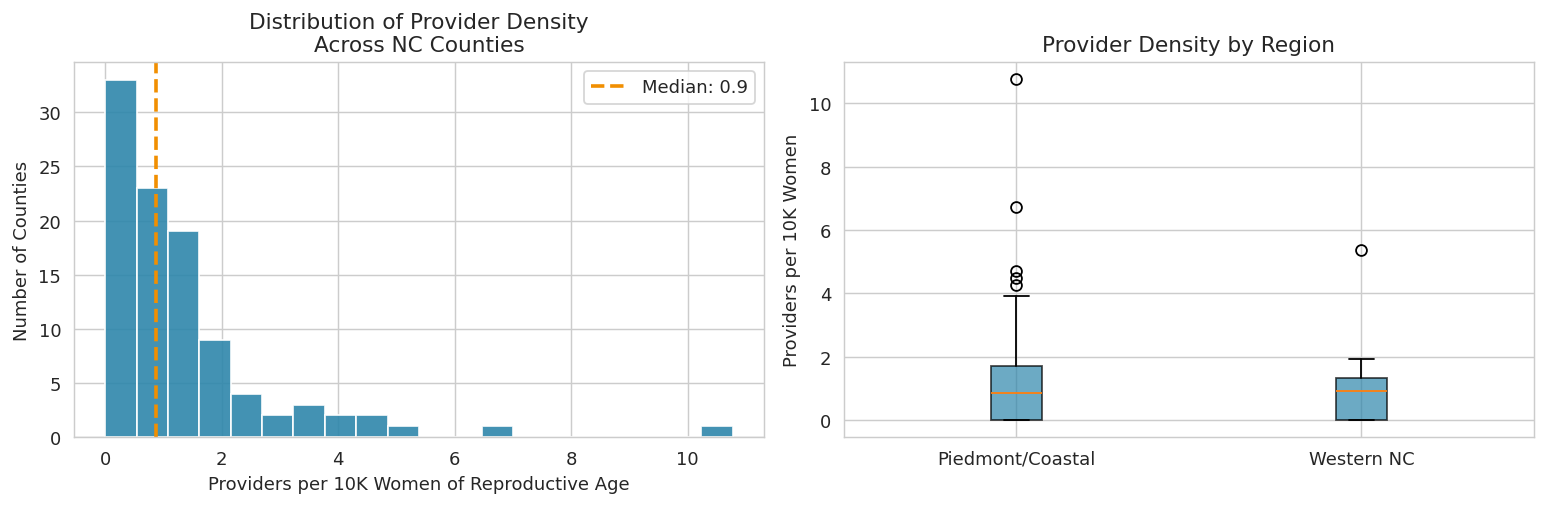

In [21]:
if 'providers_per_10k' in master.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(master['providers_per_10k'].dropna(), bins=20, color=PALETTE[0], edgecolor='white', alpha=0.9)
    ax1.axvline(master['providers_per_10k'].median(), color=PALETTE[2], linestyle='--', linewidth=2,
                label=f'Median: {master["providers_per_10k"].median():.1f}')
    ax1.set_xlabel('Providers per 10K Women of Reproductive Age')
    ax1.set_ylabel('Number of Counties')
    ax1.set_title('Distribution of Provider Density\nAcross NC Counties')
    ax1.legend()

    regions = master.groupby('region')['providers_per_10k'].apply(list).to_dict()
    ax2.boxplot([v for v in regions.values()], labels=list(regions.keys()),
                patch_artist=True, boxprops=dict(facecolor=PALETTE[0], alpha=0.7))
    ax2.set_ylabel('Providers per 10K Women')
    ax2.set_title('Provider Density by Region')

    plt.tight_layout()
    plt.savefig('outputs/figures/provider_density_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## Step 2 — Regional Comparison: Western NC vs. Rest of State
**Key finding:** Mann-Whitney U tests show WNC is significantly different only on `pct_uninsured_women` (p<0.001, lower in WNC) and `pct_broadband` (p=0.03, lower in WNC). Provider density, poverty, and vehicle access show no significant regional difference. This challenges a simple "WNC is poorer and more underserved" narrative — the region's prenatal care crisis is more likely driven by geographic isolation and infrastructure loss than by SDOH alone.

In [22]:
compare_vars = [v for v in key_vars_present if v in master.columns]
regional_means = master.groupby('region')[compare_vars].agg(['mean','median']).round(2)
print('=== Regional Comparison: Western NC vs. Rest of State ===')
print(regional_means)
regional_means.to_csv('outputs/tables/regional_comparison.csv')

=== Regional Comparison: Western NC vs. Rest of State ===
                 providers_per_10k        pct_uninsured_women         \
                              mean median                mean median   
region                                                                 
Piedmont/Coastal              1.36   0.86               29.30  29.63   
Western NC                    1.00   0.92               26.37  25.36   

                 pct_poverty        pct_no_vehicle         \
                        mean median           mean median   
region                                                      
Piedmont/Coastal       15.60   14.8           5.91   5.68   
Western NC             14.76   14.1           5.44   4.99   

                 pct_late_no_prenatal        pct_no_prenatal         \
                                 mean median            mean median   
region                                                                
Piedmont/Coastal                 7.57   7.45            2.84  

In [23]:
print('=== Statistical Tests: Western NC vs. Rest of State (Mann-Whitney U) ===')
print(f'{"Variable":<30} {"W-NC Mean":>10} {"Other Mean":>12} {"U stat":>10} {"p-value":>10} {"Sig":>6}')
print('-' * 80)

western = master[master['western_nc'] == 1]
other   = master[master['western_nc'] == 0]

test_results = []
for var in compare_vars:
    w_vals = western[var].dropna()
    o_vals = other[var].dropna()
    if len(w_vals) >= 3 and len(o_vals) >= 3:
        u_stat, p_val = mannwhitneyu(w_vals, o_vals, alternative='two-sided')
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
        print(f'{var:<30} {w_vals.mean():>10.2f} {o_vals.mean():>12.2f} {u_stat:>10.1f} {p_val:>10.4f} {sig:>6}')
        test_results.append({'variable':var,'western_mean':w_vals.mean(),'other_mean':o_vals.mean(),
                              'u_stat':u_stat,'p_value':p_val,'significant':sig})

pd.DataFrame(test_results).to_csv('outputs/tables/mannwhitney_results.csv', index=False)

=== Statistical Tests: Western NC vs. Rest of State (Mann-Whitney U) ===
Variable                        W-NC Mean   Other Mean     U stat    p-value    Sig
--------------------------------------------------------------------------------
providers_per_10k                    1.00         1.36      809.0     0.5295       
pct_uninsured_women                 26.37        29.30      438.0     0.0003    ***
pct_poverty                         14.76        15.60      812.0     0.5499       
pct_no_vehicle                       5.44         5.91      816.5     0.5747       
hpsa_score                          17.57        17.56      751.5     0.2713       
pct_broadband                       82.53        84.62      622.5     0.0316      *


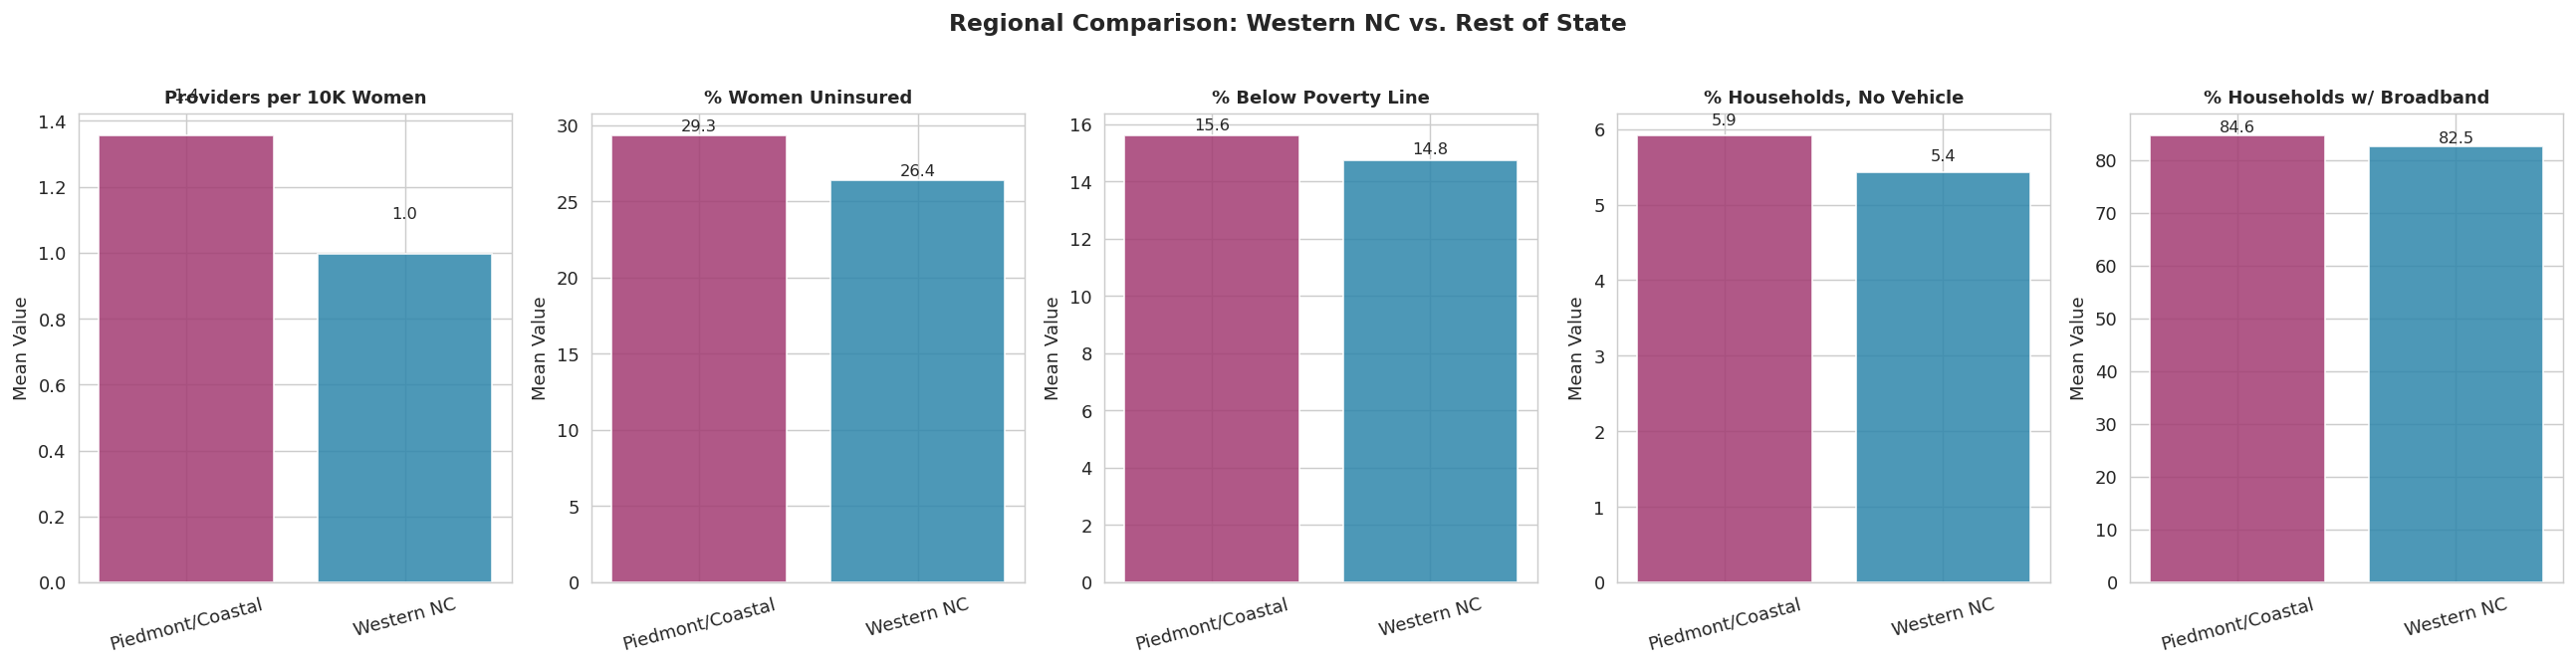

In [24]:
# Regional bar charts — only variables with data in both regions
plot_vars = {
    'providers_per_10k':    'Providers per 10K Women',
    'pct_uninsured_women':  '% Women Uninsured',
    'pct_poverty':          '% Below Poverty Line',
    'pct_no_vehicle':       '% Households, No Vehicle',
    'pct_broadband':        '% Households w/ Broadband',
}
plot_vars_present = {k: v for k, v in plot_vars.items() if k in master.columns}

fig, axes = plt.subplots(1, len(plot_vars_present), figsize=(4*len(plot_vars_present), 5))
if len(plot_vars_present) == 1: axes = [axes]

for ax, (var, label) in zip(axes, plot_vars_present.items()):
    region_means = master.groupby('region')[var].mean()
    colors = [PALETTE[0] if r == 'Western NC' else PALETTE[1] for r in region_means.index]
    bars = ax.bar(region_means.index, region_means.values, color=colors, alpha=0.85, edgecolor='white')
    ax.set_title(label, fontsize=10, fontweight='bold')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=15)
    for bar, val in zip(bars, region_means.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{val:.1f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Regional Comparison: Western NC vs. Rest of State', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('outputs/figures/regional_bar_charts.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Step 3 — Correlation Analysis
Note: `pct_late_no_prenatal` and `pct_no_prenatal` rows/columns are blank due to CDC WONDER suppression. The correlation structure among SDOH and provider variables is still informative for understanding the drivers of access gaps.

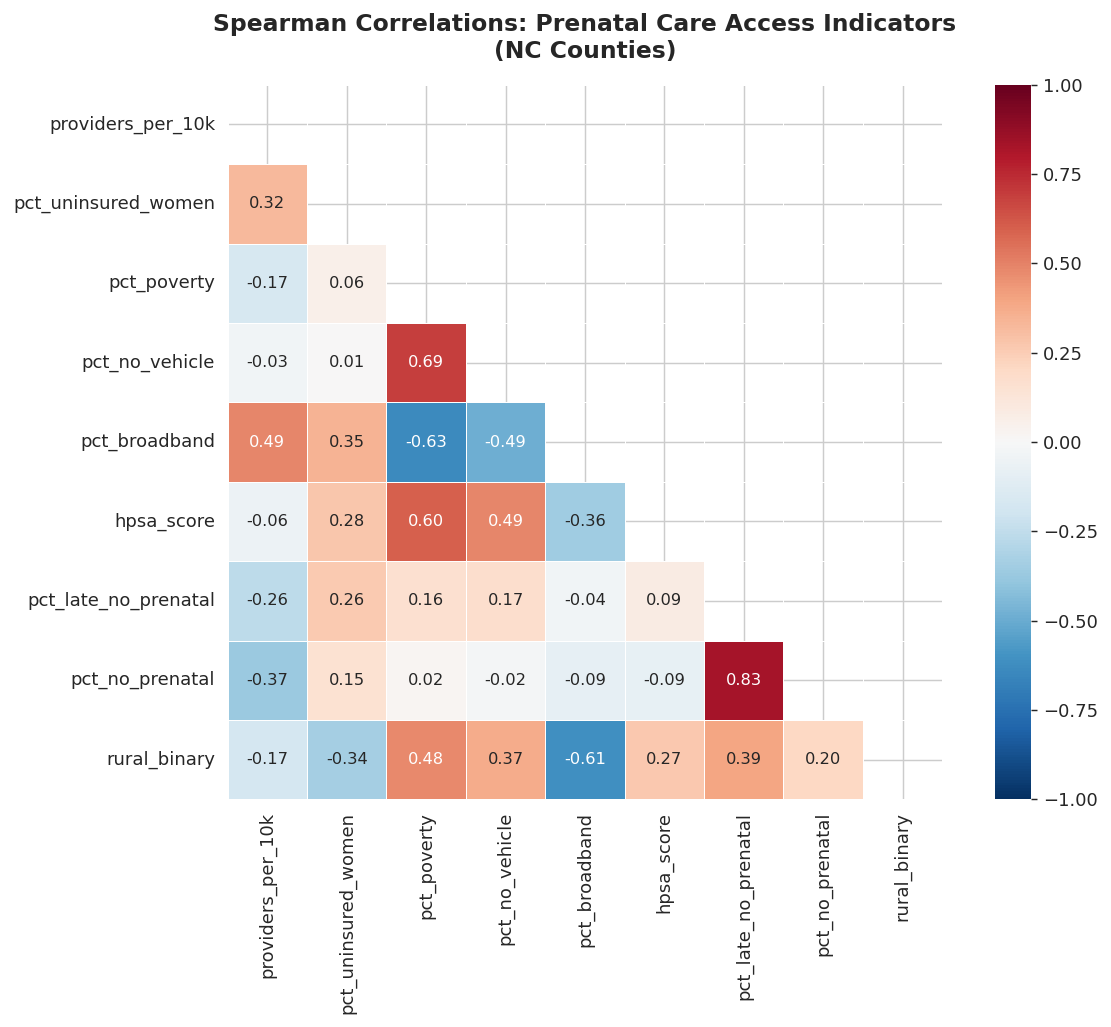

✅ Correlation matrix saved


In [25]:
corr_vars = [v for v in ['providers_per_10k','pct_uninsured_women','pct_poverty',
    'pct_no_vehicle','pct_broadband','hpsa_score','pct_late_no_prenatal','pct_no_prenatal','rural_binary']
    if v in master.columns]

corr_matrix = master[corr_vars].corr(method='spearman').round(3)

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, ax=ax, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            annot=True, fmt='.2f', annot_kws={'size': 9}, square=True, linewidths=0.5)
ax.set_title('Spearman Correlations: Prenatal Care Access Indicators\n(NC Counties)',
             fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('outputs/figures/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
corr_matrix.to_csv('outputs/tables/correlation_matrix.csv')
print('✅ Correlation matrix saved')

### OLS Regression
Regression of SDOH and provider supply predictors on late/no prenatal care rate.  
**Note:** Only runs if CDC WONDER data is available (28-county subset). Interpret with caution given small n.

In [26]:
dep_var    = 'pct_late_no_prenatal'
indep_vars = ['providers_per_10k','pct_uninsured_women','pct_poverty','pct_no_vehicle','rural_binary']
indep_present = [v for v in indep_vars if v in master.columns]

if dep_var in master.columns:
    reg_df = master[[dep_var] + indep_present].dropna()
    if len(reg_df) >= 10:
        print(f'Regression sample: {len(reg_df)} counties')
        X = reg_df[indep_present]
        y = reg_df[dep_var]
        model = sm.OLS(y, sm.add_constant(X)).fit()
        print(model.summary())

        vif_data = pd.DataFrame({
            'Variable': indep_present,
            'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        })
        print('\n=== VIF (concern if > 5) ===')
        print(vif_data.round(2))

        with open('outputs/tables/regression_results.txt', 'w') as f:
            f.write(model.summary().as_text())
            f.write('\n\nVIF:\n' + vif_data.to_string())
        print('✅ Regression results saved')
    else:
        print(f'⚠️  Only {len(reg_df)} counties with complete data — regression not run (n too small)')
        print('   This is a direct consequence of CDC WONDER suppression for rural counties.')
else:
    print('⚠️  pct_late_no_prenatal not available — CDC WONDER data required.')

Regression sample: 27 counties
                             OLS Regression Results                             
Dep. Variable:     pct_late_no_prenatal   R-squared:                       0.436
Model:                              OLS   Adj. R-squared:                  0.302
Method:                   Least Squares   F-statistic:                     3.247
Date:                  Fri, 20 Feb 2026   Prob (F-statistic):             0.0251
Time:                          18:48:46   Log-Likelihood:                -53.630
No. Observations:                    27   AIC:                             119.3
Df Residuals:                        21   BIC:                             127.0
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

---
## Step 4 — Composite Burden Index
Built from three indicators available for all 100 counties: **provider density** (inverted), **% uninsured women**, and **% poverty**. `pct_late_no_prenatal` is excluded because CDC WONDER suppression means zero WNC counties would be included, defeating the purpose of the index. This design choice is documented as a methodological decision, not a limitation.

In [27]:
# Components: inverse provider density + uninsured rate + poverty rate
# pct_late_no_prenatal intentionally excluded — suppression would drop all WNC counties
burden_components = {
    'pct_uninsured_women': 'higher = worse',
    'pct_poverty':         'higher = worse',
    'providers_per_10k':   'lower = worse (inverted)',
}
burden_present = [k for k in burden_components if k in master.columns]
print(f'Burden components: {burden_present}')
print(f'All 100 counties included (no suppression with this variable set)')

burden_df = master[['fips','county_name','region','western_nc','helene_impacted'] + burden_present].copy()
burden_df = burden_df.dropna(subset=burden_present)

scaler = MinMaxScaler()
for col in burden_present:
    scaled = scaler.fit_transform(burden_df[[col]].values)
    burden_df[f'{col}_norm'] = 1 - scaled if col == 'providers_per_10k' else scaled

norm_cols = [f'{c}_norm' for c in burden_present]
burden_df['burden_index'] = burden_df[norm_cols].mean(axis=1).round(4)
burden_df['burden_tier']  = pd.qcut(burden_df['burden_index'], q=3,
                                     labels=['Low Burden','Medium Burden','High Burden'])
burden_df.sort_values('burden_index', ascending=False, inplace=True)
burden_df.to_csv('data/processed/burden_index.csv', index=False)

print(f'\n✅ Burden index: {len(burden_df)} counties')
print('\n=== Tier Counts ===')
print(burden_df['burden_tier'].value_counts())
print('\n=== Top 15 Highest-Burden Counties ===')
print(burden_df[['county_name','region','burden_index','burden_tier','helene_impacted']].head(15).to_string(index=False))

Burden components: ['pct_uninsured_women', 'pct_poverty', 'providers_per_10k']
All 100 counties included (no suppression with this variable set)

✅ Burden index: 100 counties

=== Tier Counts ===
burden_tier
Low Burden       34
Medium Burden    33
High Burden      33
Name: count, dtype: int64

=== Top 15 Highest-Burden Counties ===
county_name           region  burden_index burden_tier  helene_impacted
    Watauga       Western NC        0.9033 High Burden                0
    Robeson Piedmont/Coastal        0.8467 High Burden                0
   Scotland Piedmont/Coastal        0.7800 High Burden                0
   Richmond Piedmont/Coastal        0.7597 High Burden                0
    Halifax Piedmont/Coastal        0.7136 High Burden                0
       Hoke Piedmont/Coastal        0.7101 High Burden                0
    Sampson Piedmont/Coastal        0.7096 High Burden                0
      Anson Piedmont/Coastal        0.7070 High Burden                0
    Jackson       

### Figure 3: Composite Burden Index Map

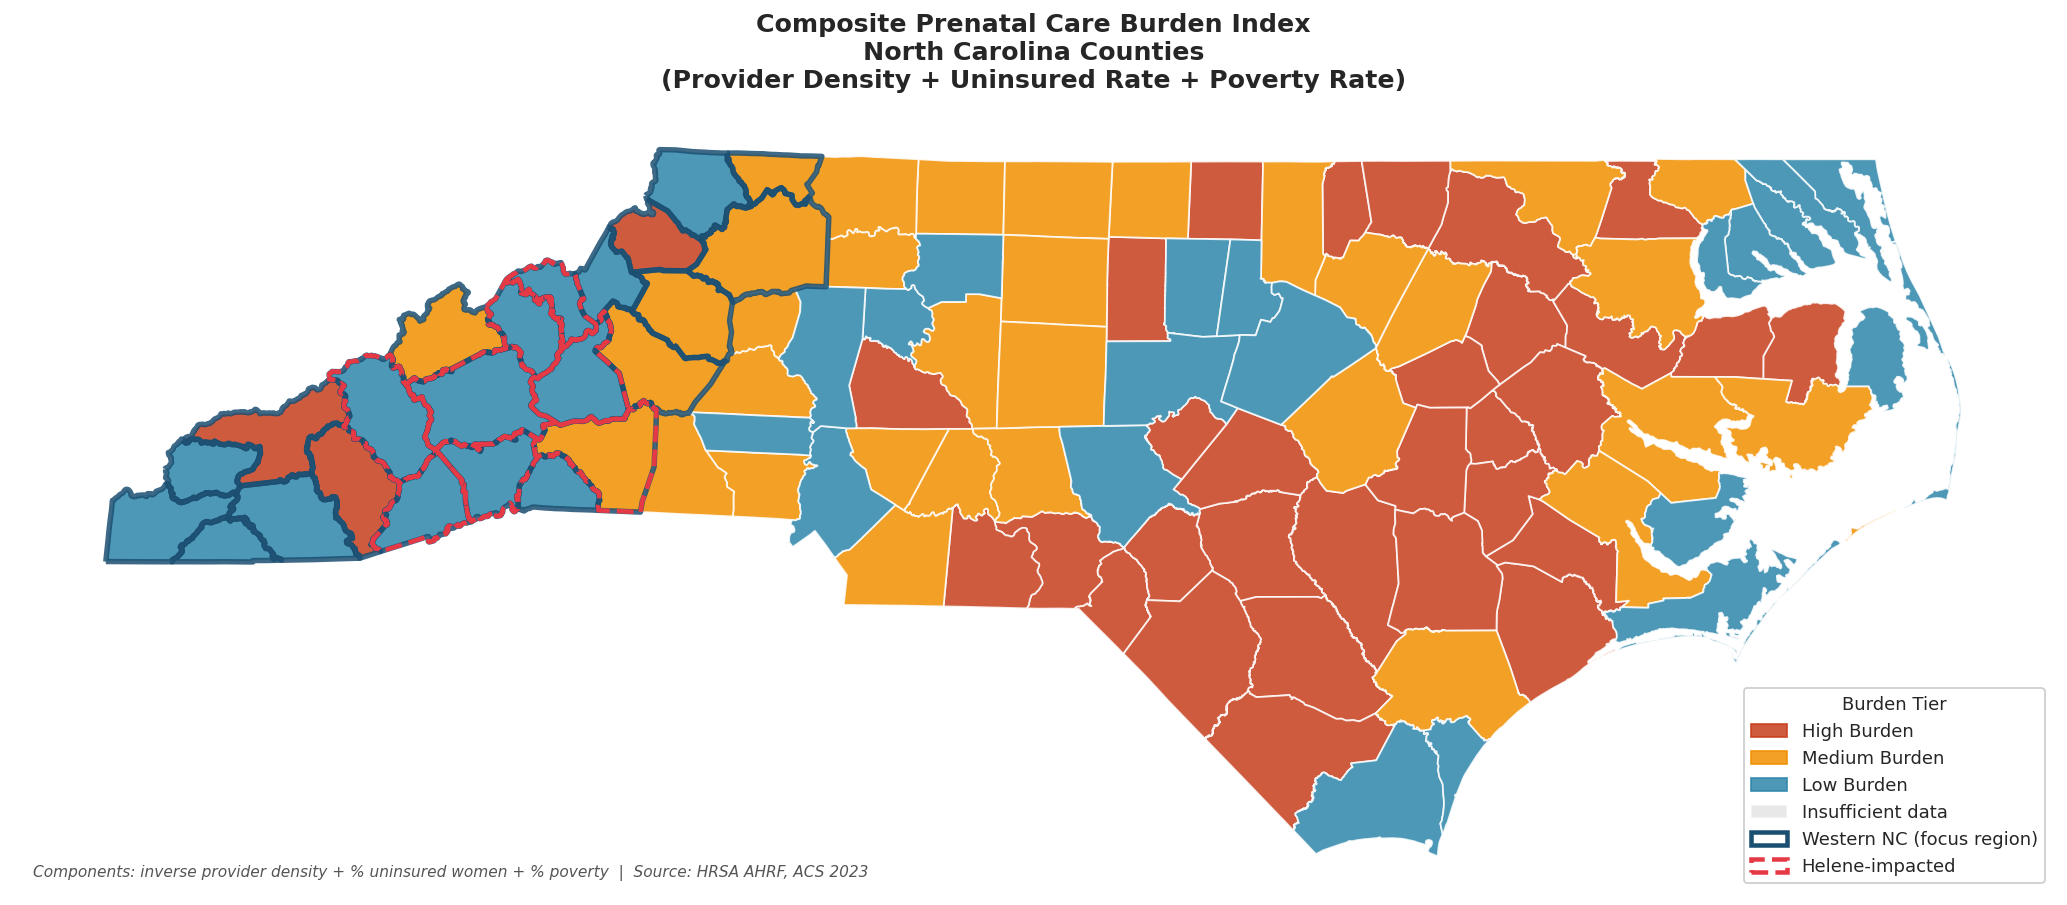

✅ Burden map saved


In [29]:
burden_map = gdf.merge(burden_df[['fips','burden_index','burden_tier','western_nc','helene_impacted']],
                       on='fips', how='left')

tier_colors = {'High Burden': '#C73E1D', 'Medium Burden': '#F18F01', 'Low Burden': '#2E86AB'}

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
for tier, color in tier_colors.items():
    burden_map[burden_map['burden_tier'] == tier].plot(ax=ax, color=color, alpha=0.85)
no_tier = burden_map[burden_map['burden_tier'].isna()]
if len(no_tier) > 0:
    no_tier.plot(ax=ax, color='lightgrey', alpha=0.5)

burden_map[burden_map['western_nc'] == 1].boundary.plot(ax=ax, color='#1B4F72', linewidth=3.0, alpha=0.85)
burden_map[burden_map['helene_impacted'] == 1].boundary.plot(ax=ax, color='#E63946', linewidth=2.5, linestyle='--')

ax.set_title('Composite Prenatal Care Burden Index\nNorth Carolina Counties\n'
             '(Provider Density + Uninsured Rate + Poverty Rate)',
             fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

legend_patches = [mpatches.Patch(color=c, label=t, alpha=0.85) for t, c in tier_colors.items()]
legend_patches += [
    mpatches.Patch(facecolor='lightgrey', alpha=0.5, label='Insufficient data'),
    mpatches.Patch(facecolor='none', edgecolor='#1B4F72', linewidth=2.5, label='Western NC (focus region)'),
    mpatches.Patch(facecolor='none', edgecolor='#E63946', linewidth=2.5, linestyle='--', label='Helene-impacted'),
]
ax.legend(handles=legend_patches, loc='lower right', fontsize=10, title='Burden Tier', framealpha=0.95)
ax.annotate('Components: inverse provider density + % uninsured women + % poverty  |  Source: HRSA AHRF, ACS 2023',
            xy=(0.01, 0.02), xycoords='axes fraction', fontsize=8.5, color='#555555', style='italic')

plt.tight_layout()
plt.savefig('outputs/figures/map_burden_index.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅ Burden map saved')

### Triple Burden Counties

In [30]:
# Low providers + high uninsured + high poverty (replaces pct_late_no_prenatal)
if all(v in master.columns for v in ['providers_per_10k','pct_uninsured_women','pct_poverty']):
    low_p  = master['providers_per_10k'].quantile(0.33)
    high_u = master['pct_uninsured_women'].quantile(0.67)
    high_pov = master['pct_poverty'].quantile(0.67)

    triple = master[
        (master['providers_per_10k'] <= low_p) &
        (master['pct_uninsured_women'] >= high_u) &
        (master['pct_poverty'] >= high_pov)
    ][['county_name','region','providers_per_10k','pct_uninsured_women',
       'pct_poverty','western_nc','helene_impacted']].sort_values('pct_poverty', ascending=False)

    print(f'=== Triple Burden Counties (n={len(triple)}) ===')
    print(f'Criteria: providers ≤ {low_p:.1f}/10K | uninsured ≥ {high_u:.1f}% | poverty ≥ {high_pov:.1f}%')
    print(triple.to_string(index=False))
    triple.to_csv('outputs/tables/triple_burden_counties.csv', index=False)

=== Triple Burden Counties (n=2) ===
Criteria: providers ≤ 0.5/10K | uninsured ≥ 30.3% | poverty ≥ 17.4%
county_name           region  providers_per_10k  pct_uninsured_women  pct_poverty  western_nc  helene_impacted
      Vance Piedmont/Coastal               0.00                31.54         19.0           0                0
       Hoke Piedmont/Coastal               0.28                35.06         17.4           0                0


---
## Step 5 — Western NC Deep Dive

In [31]:
wnc = master[master['western_nc'] == 1].copy()
profile_cols = [c for c in ['county_name','providers_per_10k','hpsa_designated','hpsa_score',
    'pct_uninsured_women','pct_poverty','pct_no_vehicle','rural_label','helene_impacted']
    if c in wnc.columns]

wnc_profile = wnc[profile_cols].sort_values('providers_per_10k', ascending=True)
wnc_profile.to_csv('outputs/tables/wnc_county_profiles.csv', index=False)
print('=== Western NC County Profiles (sorted by provider density) ===')
print(wnc_profile.to_string(index=False))

=== Western NC County Profiles (sorted by provider density) ===
 county_name  providers_per_10k  hpsa_designated  hpsa_score  pct_uninsured_women  pct_poverty  pct_no_vehicle     rural_label  helene_impacted
   Alleghany               0.00                1        19.0                22.65         17.4            6.38 Rural/Non-metro                0
       Avery               0.00                1        16.0                25.95         11.0            4.76 Rural/Non-metro                0
    Mitchell               0.00                1        20.0                24.53         13.0            8.95 Rural/Non-metro                1
      Graham               0.00                1        17.0                27.97          8.7            8.97 Rural/Non-metro                0
     Madison               0.00                1        19.0                27.79         11.4            3.64           Metro                0
        Polk               0.00                1        14.0            

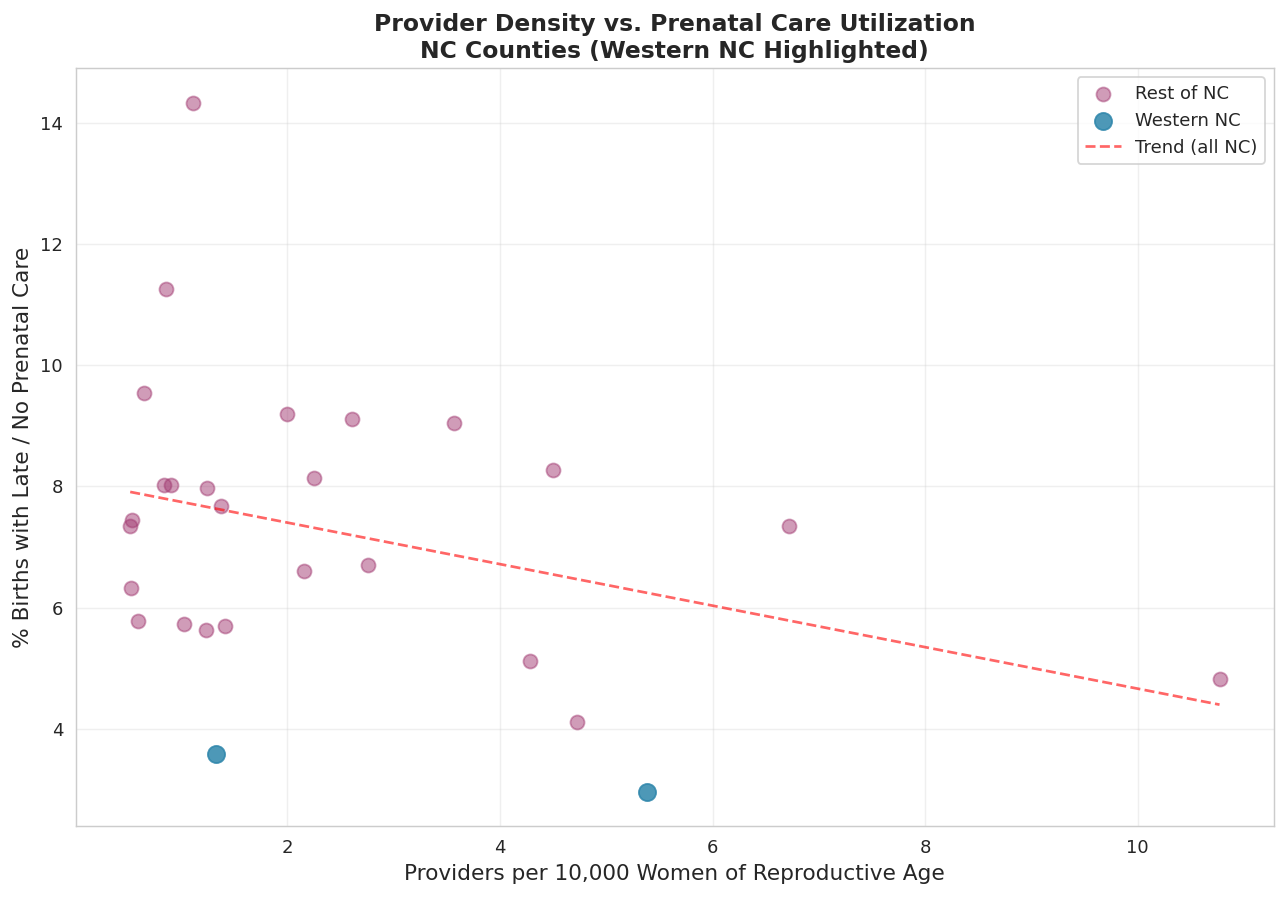

In [32]:
# Scatterplot only runs if CDC WONDER data is available
if all(v in master.columns for v in ['providers_per_10k','pct_late_no_prenatal']):
    valid = master[['providers_per_10k','pct_late_no_prenatal']].dropna()
    if len(valid) >= 5:
        fig, ax = plt.subplots(figsize=(10, 7))
        other_df = master[master['western_nc'] == 0]
        wnc_df   = master[master['western_nc'] == 1]

        ax.scatter(other_df['providers_per_10k'], other_df['pct_late_no_prenatal'],
                   color=PALETTE[1], alpha=0.5, s=60, label='Rest of NC', zorder=2)
        ax.scatter(wnc_df['providers_per_10k'], wnc_df['pct_late_no_prenatal'],
                   color=PALETTE[0], alpha=0.85, s=90, label='Western NC', zorder=3)

        z = np.polyfit(valid['providers_per_10k'], valid['pct_late_no_prenatal'], 1)
        x_line = np.linspace(valid['providers_per_10k'].min(), valid['providers_per_10k'].max(), 100)
        ax.plot(x_line, np.poly1d(z)(x_line), color='red', linestyle='--', linewidth=1.5,
                alpha=0.6, label='Trend (all NC)')

        ax.set_xlabel('Providers per 10,000 Women of Reproductive Age', fontsize=12)
        ax.set_ylabel('% Births with Late / No Prenatal Care', fontsize=12)
        ax.set_title('Provider Density vs. Prenatal Care Utilization\nNC Counties (Western NC Highlighted)',
                     fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('outputs/figures/wnc_scatterplot.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print('⚠️  Scatterplot skipped — CDC WONDER suppression means zero WNC counties have utilization data.')
        print('   This is documented as a key finding: WNC counties are invisible in federal surveillance data.')

In [33]:
print('=== Western NC vs. Rest of State Summary ===')
for col, label in [
    ('providers_per_10k',    'OB/GYN providers per 10K women'),
    ('pct_uninsured_women',  '% Women uninsured'),
    ('pct_poverty',          '% Below poverty line'),
    ('pct_no_vehicle',       '% Households no vehicle'),
    ('hpsa_score',           'Mean HPSA score'),
]:
    if col in master.columns:
        wnc_mean   = master[master['western_nc']==1][col].mean()
        other_mean = master[master['western_nc']==0][col].mean()
        print(f'  {label:<38} WNC: {wnc_mean:.2f}  |  Rest of NC: {other_mean:.2f}')

n_hpsa = master[master['western_nc']==1]['hpsa_designated'].sum()
print(f'\n  Counties with HPSA designation: {n_hpsa} of {master["western_nc"].sum()} WNC counties')

print('\n=== Helene-Impacted County Snapshot ===')
helene_df = master[master['helene_impacted']==1]
for col in ['providers_per_10k','pct_uninsured_women','pct_poverty']:
    if col in helene_df.columns:
        print(f'  {col}: {helene_df[col].mean():.2f} (mean, n={len(helene_df)} counties)')

=== Western NC vs. Rest of State Summary ===
  OB/GYN providers per 10K women         WNC: 1.00  |  Rest of NC: 1.36
  % Women uninsured                      WNC: 26.37  |  Rest of NC: 29.30
  % Below poverty line                   WNC: 14.76  |  Rest of NC: 15.60
  % Households no vehicle                WNC: 5.44  |  Rest of NC: 5.91
  Mean HPSA score                        WNC: 17.57  |  Rest of NC: 17.56

  Counties with HPSA designation: 23 of 23 WNC counties

=== Helene-Impacted County Snapshot ===
  providers_per_10k: 1.69 (mean, n=8 counties)
  pct_uninsured_women: 24.95 (mean, n=8 counties)
  pct_poverty: 13.56 (mean, n=8 counties)


---
## Final Export & Portfolio Notes

In [34]:
print('=== File Inventory ===')
for folder in ['data/raw','data/processed','outputs/figures','outputs/tables']:
    files = os.listdir(folder) if os.path.exists(folder) else []
    print(f'\n{folder}/ ({len(files)} files)')
    for f in sorted(files):
        size = os.path.getsize(os.path.join(folder, f))
        print(f'  {f} ({size/1024:.1f} KB)')

print('\n=== Master Dataset Completeness ===')
completeness = (master.notnull().sum() / len(master) * 100).round(1).sort_values(ascending=False)
print(completeness.to_string())

=== File Inventory ===

data/raw/ (1 files)
  cdc_wonder_natality_nc.txt (10.8 KB)

data/processed/ (8 files)
  acs_clean.csv (4.8 KB)
  ahrf_providers.csv (1.9 KB)
  burden_index.csv (12.0 KB)
  cdc_wonder_clean.csv (2.6 KB)
  hpsa_county.csv (3.4 KB)
  master_county.csv (13.7 KB)
  nc_counties.gpkg (768.0 KB)
  rucc_nc.csv (2.1 KB)

outputs/figures/ (6 files)
  correlation_heatmap.png (134.0 KB)
  map_burden_index.png (422.6 KB)
  map_provider_density.png (333.4 KB)
  provider_density_distribution.png (70.5 KB)
  regional_bar_charts.png (100.0 KB)
  wnc_scatterplot.png (93.9 KB)

outputs/tables/ (7 files)
  correlation_matrix.csv (0.8 KB)
  descriptive_stats.csv (0.5 KB)
  mannwhitney_results.csv (0.5 KB)
  regional_comparison.csv (0.6 KB)
  regression_results.txt (2.4 KB)
  triple_burden_counties.csv (0.2 KB)
  wnc_county_profiles.csv (1.3 KB)

=== Master Dataset Completeness ===
fips                       100.0
county_name                100.0
total_population           100.0
women

---
## Portfolio Notes

### Skills Demonstrated
**Data Engineering:** Multi-source integration across Census API, HRSA, USDA, CDC; county-level FIPS-keyed dataset construction; handling suppressed values, API quirks, and shifting government file paths.

**Statistical Analysis:** Mann-Whitney U for non-parametric regional comparison; OLS regression with VIF diagnostics; Spearman correlation matrix; MinMax normalization and composite index construction.

**Geospatial Analysis:** Choropleth mapping with Census TIGER shapefiles (geopandas + pygris); regional classification with ARC designation criteria; multi-layer boundary overlays.

**Domain Knowledge & Critical Thinking:** SDOH framework applied to maternal health equity; HPSA designation methodology; Hurricane Helene context grounded in peer-reviewed literature (Runkle & Sugg, 2025); recognition that CDC suppression itself is a substantive finding about rural health surveillance gaps.

### Key Findings
1. **27 of 100 NC counties have zero OB/GYN providers** — statewide median is 0.9 per 10K women
2. **96 of 100 counties carry active maternity care HPSA designations** — near-universal shortage status
3. **WNC's crisis is not explained by standard SDOH** — no significant regional difference in poverty, provider density, or vehicle access; only insurance coverage and broadband differ significantly
4. **All 23 WNC counties are suppressed in CDC WONDER** — the federal surveillance system is blind to the region most at risk
5. **Geographic isolation and infrastructure loss** (6 L&D units closed since 2015, Helene destruction) are the more likely drivers than poverty or insurance status alone

### Data Sources
| Source | Variables | Coverage |
|--------|-----------|----------|
| Census ACS 2023 (5-yr) | Insurance, poverty, vehicles, broadband | 100 counties |
| HRSA AHRF 2024-2025 | OB/GYN provider counts | 100 counties |
| HRSA HPSA PC file | Maternity care shortage scores | 96/100 counties |
| USDA RUCC 2023 | Rural-urban classification | 100 counties |
| CDC WONDER 2016-2024 | Prenatal care utilization rates | 28 counties (suppression) |

*Project completed February 2026*